In [1]:
# %%
# =============================================================================
# Passo 1: Importa√ß√£o de Bibliotecas
# =============================================================================

# Bibliotecas padr√£o
import csv
import gc
from pathlib import Path

# Bibliotecas de terceiros para an√°lise e manipula√ß√£o de dados
import numpy as np
import pandas as pd
import openpyxl
from scipy.stats import skew, kurtosis, ttest_ind

# Bibliotecas para visualiza√ß√£o de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas de pr√©-processamento do Scikit-learn
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [2]:
# %%
# =============================================================================
# Passo 2: Carregamento e Concatena√ß√£o dos Dados
# =============================================================================

# --- Fun√ß√µes de Leitura Robusta (sem altera√ß√£o) ---
def detectar_delimitador(caminho_arquivo: Path, tamanho_amostra: int = 65536) -> str:
    with caminho_arquivo.open("rb") as f:
        amostra = f.read(tamanho_amostra)
    for enc in ("utf-8", "latin-1", "cp1252"):
        try:
            texto = amostra.decode(enc, errors="strict")
            dialect = csv.Sniffer().sniff(texto, delimiters=";,")
            return dialect.delimiter
        except Exception:
            continue
    return ";"

def ler_csv_robusto(caminho_arquivo: Path) -> pd.DataFrame:
    sep_detectado = detectar_delimitador(caminho_arquivo)
    encodings = ("utf-8-sig", "utf-8", "latin-1", "cp1252")
    erros = []
    for enc in encodings:
        try:
            # Usar low_memory=False para evitar infer√™ncia de tipo por chuncks, prevenindo erros
            return pd.read_csv(caminho_arquivo, sep=sep_detectado, encoding=enc, low_memory=False, engine="c")
        except Exception as e:
            erros.append((f"engine=c | {enc}", str(e)))
    
    # Fallback para engine python se o 'c' falhar
    for enc in encodings:
        try:
            return pd.read_csv(caminho_arquivo, sep=sep_detectado, encoding=enc, engine="python", on_bad_lines="skip")
        except Exception as e:
            erros.append((f"engine=python | {enc}", str(e)))
            
    msg = f"Falha ao ler {caminho_arquivo.name}. Erros:\\n" + "\\n".join([f" - {ctx}: {err}" for ctx, err in erros])
    raise RuntimeError(msg)



In [3]:
# --- Processo de Leitura e Concatena√ß√£o ---

# Caminho para a pasta com os arquivos CSV
pasta_csvs = Path.cwd() / "Bases" / "0_RAIS_Bases_Amostra" / "RAIS_Enap_amostra_"
assert pasta_csvs.exists(), f"Pasta n√£o encontrada: {pasta_csvs}"

# Listar e ler os arquivos
arquivos_csv = sorted([p for p in pasta_csvs.glob("*.csv")])
if not arquivos_csv:
    raise FileNotFoundError("Nenhum CSV encontrado na pasta indicada.")

print(f"Arquivos encontrados: {len(arquivos_csv)}")
dataframes = []
for idx, arq in enumerate(arquivos_csv, start=1):
    print(f"[{idx}/{len(arquivos_csv)}] Lendo: {arq.name} ...", end="")
    df_tmp = ler_csv_robusto(arq)
    dataframes.append(df_tmp)
    print(f" ok ({df_tmp.shape[0]} linhas, {df_tmp.shape[1]} colunas)")

# Concatena todos os DataFrames em um s√≥
print("\\nConcatenando DataFrames...")
df = pd.concat(dataframes, ignore_index=True)
print("Dimens√£o final:", df.shape)



Arquivos encontrados: 11
[1/11] Lendo: RAIS_2014_Enap_amostra.csv ... ok (1128887 linhas, 37 colunas)
[2/11] Lendo: RAIS_2015_Enap_amostra.csv ... ok (1090572 linhas, 37 colunas)
[3/11] Lendo: RAIS_2016_Enap_amostra.csv ... ok (726162 linhas, 37 colunas)
[4/11] Lendo: RAIS_2017_Enap_amostra.csv ... ok (1073850 linhas, 37 colunas)
[5/11] Lendo: RAIS_2018_Enap_amostra.csv ... ok (1082710 linhas, 37 colunas)
[6/11] Lendo: RAIS_2019_Enap_amostra.csv ... ok (796532 linhas, 37 colunas)
[7/11] Lendo: RAIS_2020_Enap_amostra.csv ... ok (1109627 linhas, 37 colunas)
[8/11] Lendo: RAIS_2021_Enap_amostra.csv ... ok (1199769 linhas, 37 colunas)
[9/11] Lendo: RAIS_2022_Enap_amostra.csv ... ok (1245516 linhas, 37 colunas)
[10/11] Lendo: RAIS_2023_Enap_amostra.csv ... ok (1328596 linhas, 37 colunas)
[11/11] Lendo: RAIS_2024_Enap_amostra.csv ... ok (985182 linhas, 37 colunas)
\nConcatenando DataFrames...
Dimens√£o final: (11767403, 37)


In [4]:
# --- Otimiza√ß√£o de Mem√≥ria ---
# Remove a lista de dataframes e o dataframe tempor√°rio da mem√≥ria
del dataframes
del df_tmp
gc.collect() # Executa o garbage collector para liberar mem√≥ria
print("Mem√≥ria liberada.")


Mem√≥ria liberada.


In [5]:
# %%
# =============================================================================
# Passo 3: Limpeza, Otimiza√ß√£o e Transforma√ß√£o dos Dados
# =============================================================================

# --- 3.1: Remo√ß√£o de Colunas Desnecess√°rias ---
colunas_para_remover = [
    "VinculoAtivo", "NRMesDesligamento", "TPAdmissao", "TPEstabelecimento", 
    "TPDeficiencia", "CDCausaAfastamento1", "CDCausaAfastamento2", "CDCausaAfastamento3", 
    "INTrabIntermitente", "VLRemunDezembroNom", "VLRemunDezembroSM", "VLSalarioContratual",
    "NRCNPJCEI", "NRCNPJRaiz", "CDCNAE20Subclasse", "Estoque_Total", "Estoque_Fem", "TPSalario"
]
existentes = [c for c in colunas_para_remover if c in df.columns]
df.drop(columns=existentes, inplace=True)
gc.collect()
print(f"Colunas removidas. Shape ap√≥s remo√ß√£o: {df.shape}")


Colunas removidas. Shape ap√≥s remo√ß√£o: (11767403, 19)


In [6]:

# --- 3.2: Limpeza de Outliers de Remunera√ß√£o ---
df.dropna(subset=["VLRemunMediaNom"], inplace=True)
df = df[(df["VLRemunMediaSM"] >= 0.3) & (df["VLRemunMediaSM"] <= 150)]
print(f"Shape ap√≥s limpeza de sal√°rios: {df.shape}")


Shape ap√≥s limpeza de sal√°rios: (11357549, 19)


In [7]:

# --- 3.3: Otimiza√ß√£o de Tipos de Dados ---
print("Otimizando tipos de dados...")

if 'CDCBOOcupacao2002' in df.columns:
    df['CDCBOOcupacao2002'] = df['CDCBOOcupacao2002'].astype(str)

colunas_categoricas = [
    "NRANO", 
    "CDDesligamento", "CDGrauEscolaridade", "CDNaturezaJuridica", "CDRacaCor", 
    "CDSexo", "CDTamanhoEstabelecimento", "INPortadorDefic", "INTrabParcial", 
    "TPVinculo", "CDCNAE20Classe", "CDMunicipio"
]


Otimizando tipos de dados...


In [8]:

# --- 3.4: Cria√ß√£o de Novas Colunas (Engenharia de Features) ---
print("Criando novas colunas...")
ocupacoes_map = {
    '0': 'FOR√áAS ARMADAS, POLICIAIS E BOMBEIROS', '1': 'DIRIGENTES E GERENTES',
    '2': 'PROFISSIONAIS DAS CI√äNCIAS E DAS ARTES', '3': 'T√âCNICOS DE N√çVEL M√âDIO', 
    '4': 'TRABALHADORES DE SERVI√áOS ADMINISTRATIVOS', '5': 'TRABALHADORES DOS SERVI√áOS E VENDEDORES',
    '6': 'TRABALHADORES AGROPECU√ÅRIOS E DA PESCA', '7': 'TRABALHADORES DA PRODU√á√ÉO INDUSTRIAL',
    '8': 'TRABALHADORES DA PRODU√á√ÉO INDUSTRIAL', '9': 'TRABALHADORES DE REPARA√á√ÉO E MANUTEN√á√ÉO'
}
df['GrupoOcupacao'] = df['CDCBOOcupacao2002'].str[0].map(ocupacoes_map).astype("category")


Criando novas colunas...


In [9]:

# --- 3.5: Filtragem por Capitais ---
print("Filtrando registros apenas das capitais...")
codigos_capitais = [
    431490, 330455, 520870, 355030, 250750, 261160, 221100, 292740, 510340, 150140, 
    410690, 270430, 230440, 240810, 280030, 110020, 120040, 130260, 500270, 310620, 
    421660, 172100, 160060, 211130, 320530, 530010
]
df['CDMunicipio'] = pd.to_numeric(df['CDMunicipio'], errors='coerce').astype('Int64')
df = df[df['CDMunicipio'].isin(codigos_capitais)].copy()


Filtrando registros apenas das capitais...


In [10]:
# --- Limpeza Final de Mem√≥ria ---
gc.collect()
print(f"Pr√©-processamento conclu√≠do. Shape final para an√°lise: {df.shape}")

Pr√©-processamento conclu√≠do. Shape final para an√°lise: (4257681, 20)


In [11]:
# %%
# =============================================================================
# Passo 4: An√°lise Explorat√≥ria e Normaliza√ß√£o da Remunera√ß√£o
# =============================================================================

# --- 4.1: An√°lise Univariada da Remunera√ß√£o (P√≥s-filtro) ---
s = df["VLRemunMediaNom"]
print("Resumo estat√≠stico da Remunera√ß√£o (P√≥s-filtro):")
display(s.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).round(2))


Resumo estat√≠stico da Remunera√ß√£o (P√≥s-filtro):


count    4257681.00
mean        4430.63
std         6556.31
min          217.20
1%           581.16
5%           914.00
25%         1460.60
50%         2222.44
75%         4463.25
95%        15583.52
99%        32883.11
max       209000.00
Name: VLRemunMediaNom, dtype: float64

In [12]:

# --- 4.2: DataFrame para testes de normaliza√ß√£o ---
df_norm = df[['VLRemunMediaNom']].copy()


# Aplica as transforma√ß√µes
df_norm['log_VLRemunMediaNom'] = np.log1p(df_norm['VLRemunMediaNom'])
df_norm['robust_VLRemunMediaNom'] = RobustScaler().fit_transform(df_norm[['VLRemunMediaNom']])
df_norm['std_VLRemunMediaNom'] = StandardScaler().fit_transform(df_norm[['VLRemunMediaNom']])
df_norm['minmax_VLRemunMediaNom'] = MinMaxScaler().fit_transform(df_norm[['VLRemunMediaNom']])
df_norm['yeoj_VLRemunMediaNom'] = PowerTransformer(method='yeo-johnson').fit_transform(df_norm[['VLRemunMediaNom']])

In [13]:
# --- 4.3: Avalia√ß√£o de Assimetria e Curtose ---
print("\nüìä Skew e Curtose das transforma√ß√µes:")
for col in df_norm.columns:
    skew_val = skew(df_norm[col].dropna())
    kurt_val = kurtosis(df_norm[col].dropna())
    print(f"{col:<30} | Skew: {skew_val:>7.3f} | Kurtosis: {kurt_val:>7.3f}")



üìä Skew e Curtose das transforma√ß√µes:
VLRemunMediaNom                | Skew:   5.939 | Kurtosis:  69.292
log_VLRemunMediaNom            | Skew:   0.861 | Kurtosis:   0.508
robust_VLRemunMediaNom         | Skew:   5.939 | Kurtosis:  69.292
std_VLRemunMediaNom            | Skew:   5.939 | Kurtosis:  69.292
minmax_VLRemunMediaNom         | Skew:   5.939 | Kurtosis:  69.292
yeoj_VLRemunMediaNom           | Skew:   0.038 | Kurtosis:  -0.101


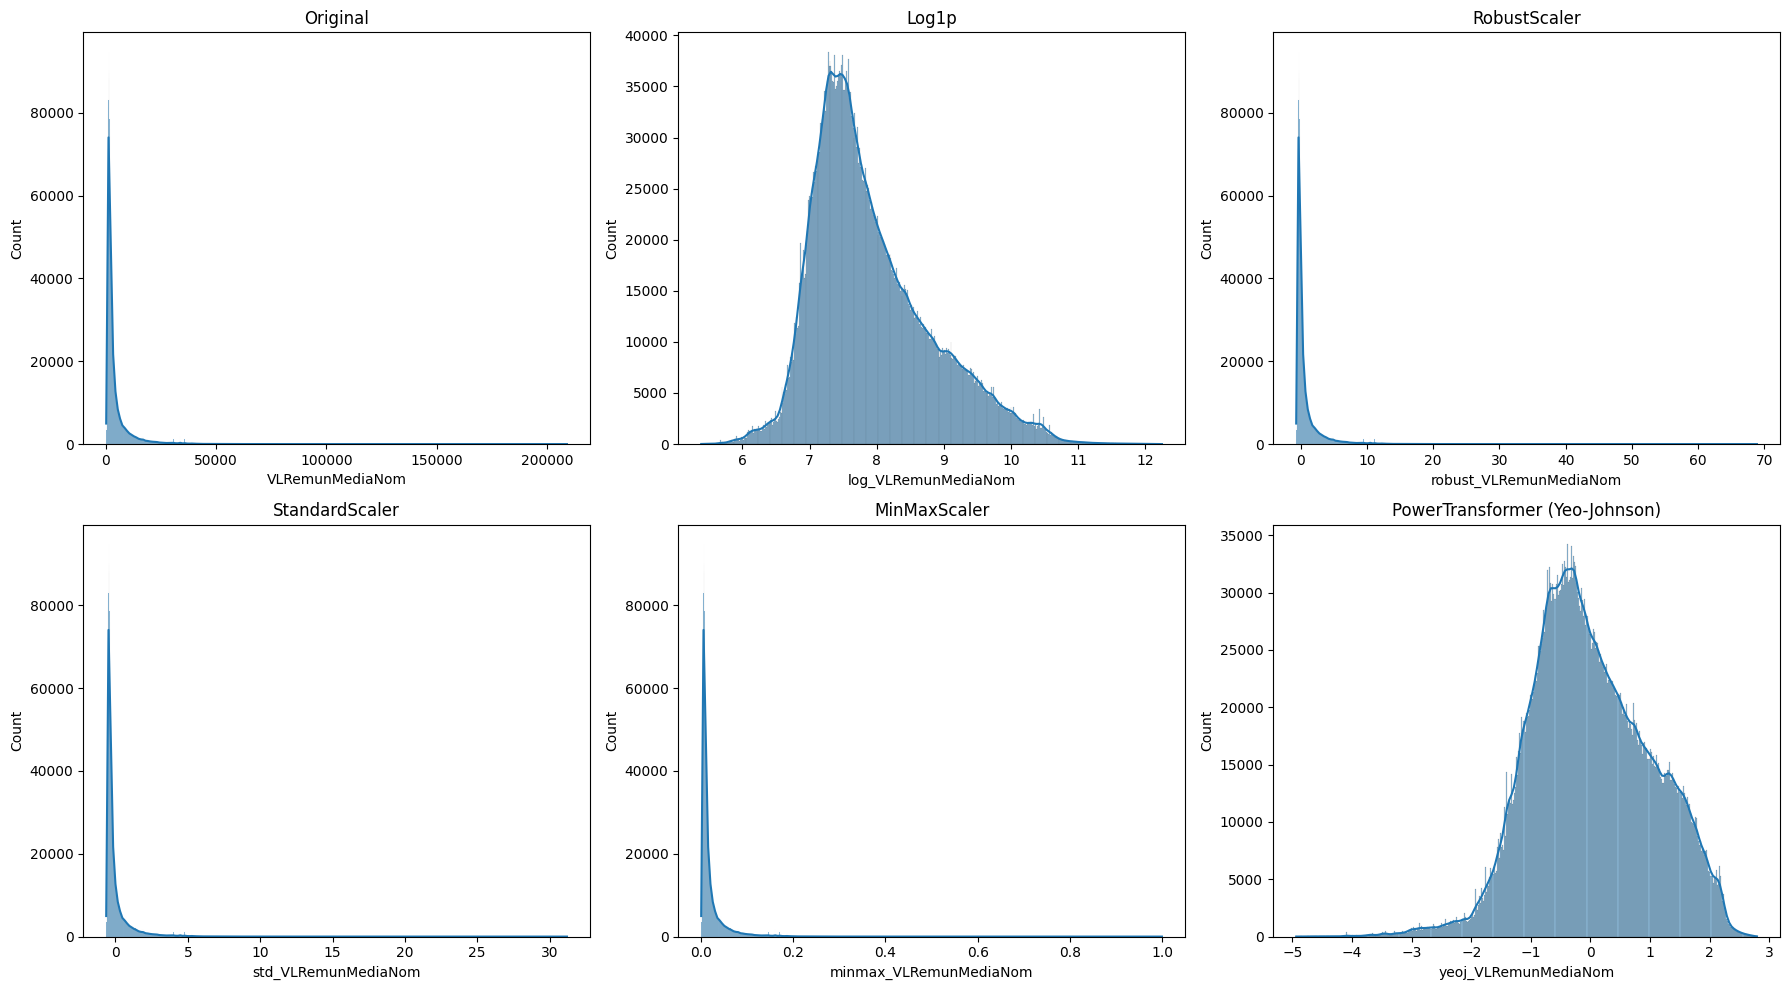

In [14]:

# --- 4.4: Visualiza√ß√£o das Distribui√ß√µes ---
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
sns.histplot(df_norm['VLRemunMediaNom'], ax=axs[0, 0], kde=True).set(title='Original')
sns.histplot(df_norm['log_VLRemunMediaNom'], ax=axs[0, 1], kde=True).set(title='Log1p')
sns.histplot(df_norm['robust_VLRemunMediaNom'], ax=axs[0, 2], kde=True).set(title='RobustScaler')
sns.histplot(df_norm['std_VLRemunMediaNom'], ax=axs[1, 0], kde=True).set(title='StandardScaler')
sns.histplot(df_norm['minmax_VLRemunMediaNom'], ax=axs[1, 1], kde=True).set(title='MinMaxScaler')
sns.histplot(df_norm['yeoj_VLRemunMediaNom'], ax=axs[1, 2], kde=True).set(title='PowerTransformer (Yeo-Johnson)')
plt.tight_layout()
plt.show()

In [15]:
# %%
# =============================================================================
# Passo 5: An√°lise de Carga Hor√°ria e Remunera√ß√£o por Sexo
# =============================================================================

# --- 5.1: Prepara√ß√£o do DataFrame ---
# Mapeamos o sexo para melhor legibilidade no DataFrame principal
df['CDSexo'] = df['CDSexo'].map({1.0: 'Masculino', 2.0: 'Feminino'}).astype("category")

# Criamos uma c√≥pia espec√≠fica para a an√°lise de horas, removendo nulos
df_horas = df.dropna(subset=['NRQtdHoraContr', 'CDSexo', 'GrupoOcupacao']).copy()

In [16]:
# --- 5.2: An√°lise da Carga Hor√°ria por Sexo (Geral) ---
print("--- An√°lise Geral por Sexo ---")
display(df_horas.groupby('CDSexo', observed=False)['NRQtdHoraContr'].describe())

# Separa√ß√£o por sexo para o teste-t
homens = df_horas[df_horas['CDSexo'] == 'Masculino']['NRQtdHoraContr']
mulheres = df_horas[df_horas['CDSexo'] == 'Feminino']['NRQtdHoraContr']
t_stat, p_valor = ttest_ind(homens, mulheres, equal_var=False)
print(f"\nEstat√≠stica t (Geral) = {t_stat:.3f} | p-valor = {p_valor:.4f}")

--- An√°lise Geral por Sexo ---


count       mean       std  min   25%   50%   75%   max
CDSexo                                                                
Feminino   1911896.0  39.046746  8.859614  0.0  36.0  40.0  44.0  99.0
Masculino  2345784.0  40.928552  8.737053  0.0  40.0  44.0  44.0  99.0


Estat√≠stica t (Geral) = 219.354 | p-valor = 0.0000


In [17]:
# --- 5.3: An√°lise da Carga Hor√°ria por Grupo Ocupacional e Sexo ---
print("\n--- An√°lise por Grupo Ocupacional e Sexo ---")
grupo_sexo_stats = (
    df_horas.groupby(['GrupoOcupacao', 'CDSexo'], observed=False)['NRQtdHoraContr']
    .agg(['count', 'mean', 'std'])
    .reset_index()
)
display(grupo_sexo_stats)


--- An√°lise por Grupo Ocupacional e Sexo ---


GrupoOcupacao     CDSexo   count       mean  \
0                       DIRIGENTES E GERENTES   Feminino  115970  39.475520   
1                       DIRIGENTES E GERENTES  Masculino  141401  39.997383   
2       FOR√áAS ARMADAS, POLICIAIS E BOMBEIROS   Feminino    5478  39.803578   
3       FOR√áAS ARMADAS, POLICIAIS E BOMBEIROS  Masculino   21676  39.709587   
4      PROFISSIONAIS DAS CI√äNCIAS E DAS ARTES   Feminino  318087  35.979113   
5      PROFISSIONAIS DAS CI√äNCIAS E DAS ARTES  Masculino  288022  36.753238   
6      TRABALHADORES AGROPECU√ÅRIOS E DA PESCA   Feminino    2323  42.203616   
7      TRABALHADORES AGROPECU√ÅRIOS E DA PESCA  Masculino   15148  42.858265   
8        TRABALHADORES DA PRODU√á√ÉO INDUSTRIAL   Feminino   72545  44.453250   
9        TRABALHADORES DA PRODU√á√ÉO INDUSTRIAL  Masculino  505060  43.369871   
10    TRABALHADORES DE REPARA√á√ÉO E MANUTEN√á√ÉO   Feminino    6066  41.470986   
11    TRABALHADORES DE REPARA√á√ÉO E MANUTEN√á√ÉO  Masculino   77079  42.626604   
12  TRABALHADORES DE SERVI√áOS ADMINISTRATIVOS   Feminino  583236  38.636629   
13  TRABALHADORES DE SERVI√áOS ADMINISTRATIVOS  Masculino  378694  39.252320   
14    TRABALHADORES DOS SERVI√áOS E VENDEDORES   Feminino  455543  41.345368   
15    TRABALHADORES DOS SERVI√áOS E VENDEDORES  Masculino  630169  42.162287   
16                    T√âCNICOS DE N√çVEL M√âDIO   Feminino  352648  38.195254   
17                    T√âCNICOS DE N√çVEL M√âDIO  Masculino  288535  40.321566   

          std  
0   11.749788  
1   11.954777  
2    1.912675  
3    1.806675  
4   11.769197  
5   12.849189  
6    3.488056  
7    4.580614  
8    9.899055  
9    7.473455  
10   9.997868  
11   6.038322  
12   7.036767  
13   7.427364  
14   7.181002  
15   6.836590  
16   7.882052  
17   8.106345

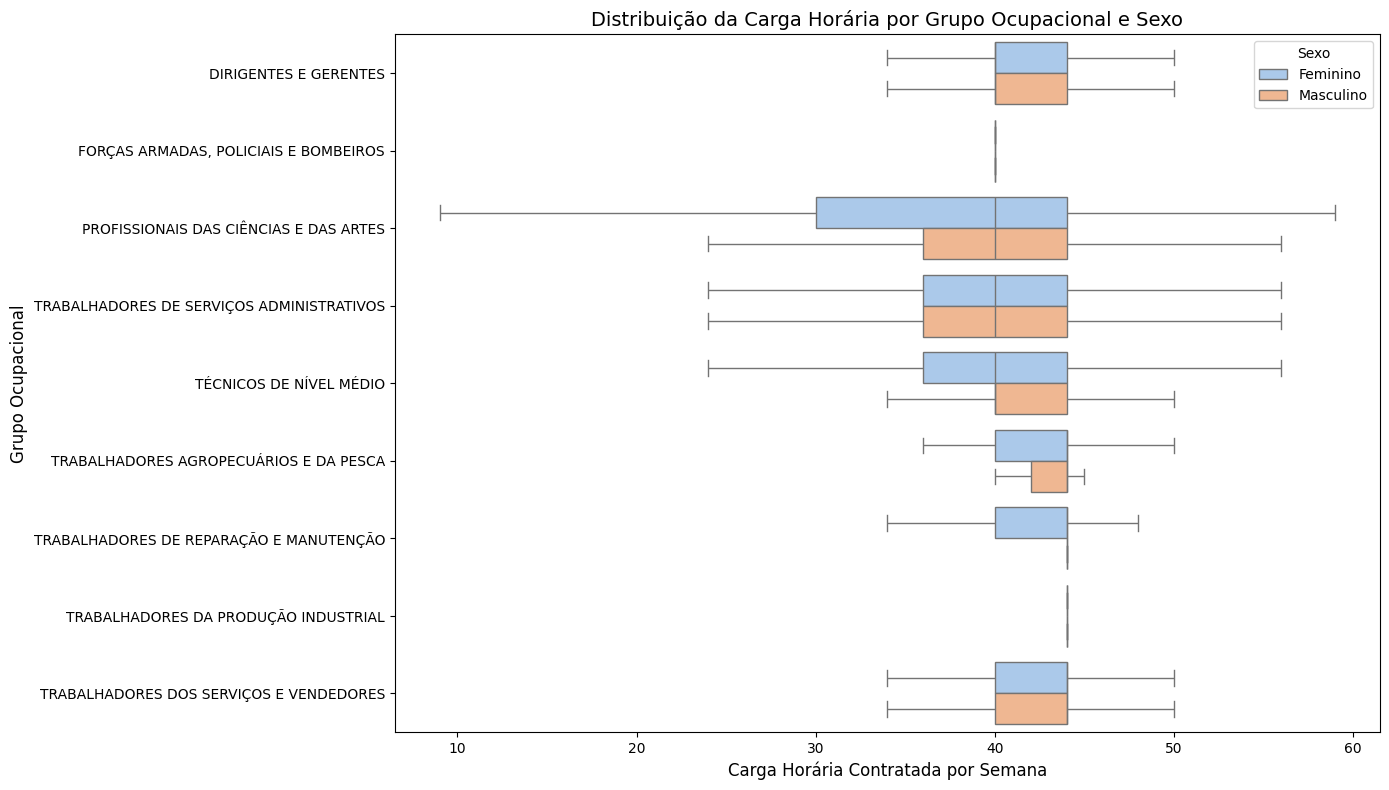

In [18]:
# --- 5.4: Visualiza√ß√£o com Boxplot ---
# Ordena os grupos pela mediana da carga hor√°ria para melhor visualiza√ß√£o
medianas = df_horas.groupby("GrupoOcupacao", observed=False)["NRQtdHoraContr"].median().sort_values()
ordem = medianas.index.tolist()

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_horas, y='GrupoOcupacao', x='NRQtdHoraContr', hue='CDSexo',
    orient='h', order=ordem, showfliers=False, palette='pastel'
)
plt.title('Distribui√ß√£o da Carga Hor√°ria por Grupo Ocupacional e Sexo', fontsize=14)
plt.xlabel('Carga Hor√°ria Contratada por Semana', fontsize=12)
plt.ylabel('Grupo Ocupacional', fontsize=12)
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

In [19]:
# --- 5.5: Salvar o DataFrame final e limpo (Opcional) ---
# Adicionando a coluna de log da remunera√ß√£o antes de salvar
df['log_VLRemunMediaNom'] = np.log1p(df['VLRemunMediaNom'])
saida_final_parquet = pasta_csvs / "RAIS_CAPITAIS_PROCESSADO_FINAL.parquet"
df.to_parquet(saida_final_parquet, index=False)

print(f"\nDataFrame final salvo com sucesso em: {saida_final_parquet}")


DataFrame final salvo com sucesso em: C:\Users\Guilherme\OneDrive\Cursos\ENAP\MBA em Intelig√™ncia Artificial\Disciplinas\18 - Lab 02\Bases\0_RAIS_Bases_Amostra\RAIS_Enap_amostra_\RAIS_CAPITAIS_PROCESSADO_FINAL.parquet


--- An√°lise da Remunera√ß√£o M√©dia por Sexo e Ano ---


CDSexo     Feminino    Masculino
NRANO                           
2014    3113.992563  3584.180238
2015    3395.443606  3982.008113
2016    3646.241496  4231.137202
2017    3828.504941  4488.850097
2018    3845.329824  4625.906958
2019    4214.726907  4901.937472
2020    4025.025277  4843.982076
2021    4127.284933  4981.466749
2022    4954.314613  5900.164003
2023    4856.327882  5659.440253
2024    4137.153573  5012.992815

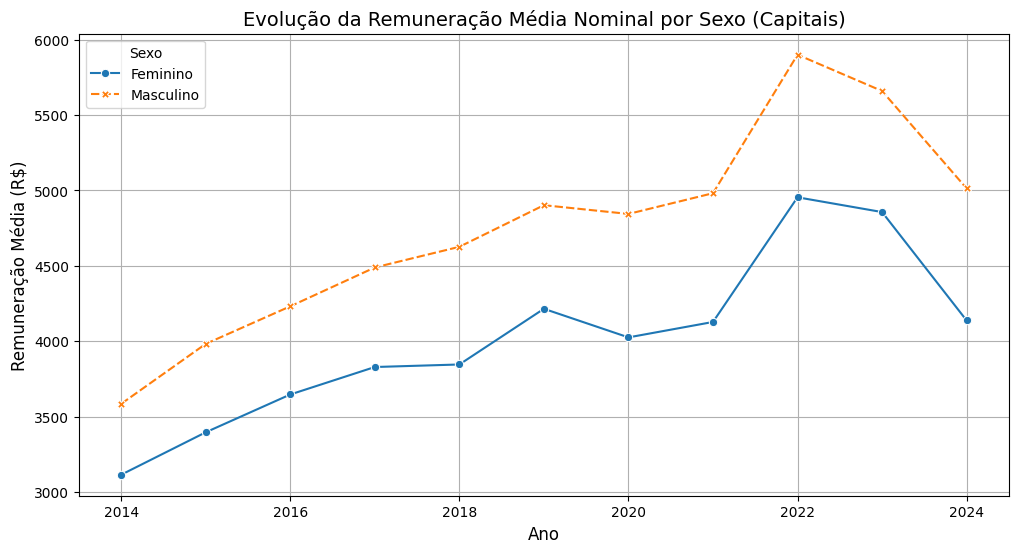

In [20]:
# %%
# =============================================================================
# Passo 6: An√°lise de Remunera√ß√£o por Sexo e Ano
# =============================================================================

# Garante que a coluna de ano seja do tipo 'category' para a an√°lise
df['NRANO'] = df['NRANO'].astype('category')

# --- 6.1: An√°lise da Remunera√ß√£o M√©dia por Sexo e Ano ---
print("--- An√°lise da Remunera√ß√£o M√©dia por Sexo e Ano ---")
df_remun = df.dropna(subset=['VLRemunMediaNom', 'CDSexo'])

# Agrupa por ano e sexo para ver a evolu√ß√£o
remuneracao_anual = df_remun.groupby(['NRANO', 'CDSexo'], observed=False)['VLRemunMediaNom'].mean().unstack()
display(remuneracao_anual)

# Gr√°fico de linhas para visualizar a tend√™ncia
plt.figure(figsize=(12, 6))
sns.lineplot(data=remuneracao_anual, markers=True)
plt.title('Evolu√ß√£o da Remunera√ß√£o M√©dia Nominal por Sexo (Capitais)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Remunera√ß√£o M√©dia (R$)', fontsize=12)
plt.legend(title='Sexo')
plt.grid(True)
plt.show()

In [21]:
# %%
# --- 6.2: Teste de Signific√¢ncia Estat√≠stica para a Diferen√ßa Salarial ---
print("\n--- Teste-t para a Diferen√ßa Salarial por Ano ---")

resultados_teste_t_salario = []
anos = df_remun['NRANO'].unique().sort_values()

for ano in anos:
    dados_ano = df_remun[df_remun['NRANO'] == ano]
    
    salarios_homens = dados_ano[dados_ano['CDSexo'] == 'Masculino']['VLRemunMediaNom']
    salarios_mulheres = dados_ano[dados_ano['CDSexo'] == 'Feminino']['VLRemunMediaNom']
    
    if len(salarios_homens) > 1 and len(salarios_mulheres) > 1:
        # Usamos o log da remunera√ß√£o para o teste, pois tem uma distribui√ß√£o mais pr√≥xima da normal
        t_stat, p_val = ttest_ind(np.log1p(salarios_homens), np.log1p(salarios_mulheres), equal_var=False)
        
        resultados_teste_t_salario.append({
            'Ano': ano,
            'Media_Salario_Masc': salarios_homens.mean(),
            'Media_Salario_Fem': salarios_mulheres.mean(),
            'Diferenca_Absoluta': salarios_homens.mean() - salarios_mulheres.mean(),
            'Diferenca_Percentual': (salarios_homens.mean() - salarios_mulheres.mean()) / salarios_homens.mean() * 100,
            'p_valor': p_val
        })

df_teste_t_salario = pd.DataFrame(resultados_teste_t_salario)
display(df_teste_t_salario.round(2))


--- Teste-t para a Diferen√ßa Salarial por Ano ---


Ano  Media_Salario_Masc  Media_Salario_Fem  Diferenca_Absoluta  \
0   2014             3584.18            3113.99              470.19   
1   2015             3982.01            3395.44              586.56   
2   2016             4231.14            3646.24              584.90   
3   2017             4488.85            3828.50              660.35   
4   2018             4625.91            3845.33              780.58   
5   2019             4901.94            4214.73              687.21   
6   2020             4843.98            4025.03              818.96   
7   2021             4981.47            4127.28              854.18   
8   2022             5900.16            4954.31              945.85   
9   2023             5659.44            4856.33              803.11   
10  2024             5012.99            4137.15              875.84   

    Diferenca_Percentual  p_valor  
0                  13.12      0.0  
1                  14.73      0.0  
2                  13.82      0.0  
3                  14.71      0.0  
4                  16.87      0.0  
5                  14.02      0.0  
6                  16.91      0.0  
7                  17.15      0.0  
8                  16.03      0.0  
9                  14.19      0.0  
10                 17.47      0.0

# Teste de hip√≥teses

In [22]:
# %%
# =============================================================================
# Passo 6: Teste-t por Grupo Ocupacional (An√°lise Reincorporada)
# =============================================================================
# Esta an√°lise verifica se a diferen√ßa de carga hor√°ria entre os sexos √© 
# estatisticamente significativa dentro de cada grupo ocupacional.

print("--- Teste-t por Grupo Ocupacional ---")
resultados_teste_t = []
for grupo in df_horas['GrupoOcupacao'].dropna().unique():
    sub = df_horas[df_horas['GrupoOcupacao'] == grupo]
    fem = sub[sub['CDSexo'] == 'Feminino']['NRQtdHoraContr']
    masc = sub[sub['CDSexo'] == 'Masculino']['NRQtdHoraContr']
    
    # Realiza o teste apenas se houver amostras para ambos os sexos
    if len(fem) > 1 and len(masc) > 1:
        t_stat, p_val = ttest_ind(masc, fem, equal_var=False)
        resultados_teste_t.append({
            'GrupoOcupacao': grupo,
            'Media_Masc': masc.mean(),
            'Media_Fem': fem.mean(),
            'Dif_Medias': masc.mean() - fem.mean(),
            't_stat': t_stat,
            'p_valor': p_val
        })

df_teste_t = pd.DataFrame(resultados_teste_t)
display(df_teste_t)

# --- Limpeza final da mem√≥ria, agora sim no final de todo o script ---
del df, df_norm, df_horas
gc.collect()
print("\nAn√°lise conclu√≠da e mem√≥ria liberada.")

--- Teste-t por Grupo Ocupacional ---


GrupoOcupacao  Media_Masc  Media_Fem  \
0                      DIRIGENTES E GERENTES   39.997383  39.475520   
1  TRABALHADORES DE SERVI√áOS ADMINISTRATIVOS   39.252320  38.636629   
2       TRABALHADORES DA PRODU√á√ÉO INDUSTRIAL   43.369871  44.453250   
3     PROFISSIONAIS DAS CI√äNCIAS E DAS ARTES   36.753238  35.979113   
4    TRABALHADORES DOS SERVI√áOS E VENDEDORES   42.162287  41.345368   
5    TRABALHADORES DE REPARA√á√ÉO E MANUTEN√á√ÉO   42.626604  41.470986   
6     TRABALHADORES AGROPECU√ÅRIOS E DA PESCA   42.858265  42.203616   
7                    T√âCNICOS DE N√çVEL M√âDIO   40.321566  38.195254   
8      FOR√áAS ARMADAS, POLICIAIS E BOMBEIROS   39.709587  39.803578   

   Dif_Medias      t_stat        p_valor  
0    0.521864   11.123196   9.826381e-29  
1    0.615691   40.547010   0.000000e+00  
2   -1.083379  -28.340206  7.344799e-176  
3    0.774125   24.374360  3.720969e-131  
4    0.816919   59.680398   0.000000e+00  
5    1.155618    8.875899   8.870745e-19  
6    0.654649    8.044438   1.158359e-15  
7    2.126312  105.798617   0.000000e+00  
8   -0.093991   -3.285513   1.022283e-03


An√°lise conclu√≠da e mem√≥ria liberada.
